<a href="https://colab.research.google.com/github/davideandres95/ml_comm/blob/main/tut07_WIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Tutorial 7: Mapper
December 9, 2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch            
from torch import nn, optim

In [34]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 

##### Problem 6.1 - One hot mapping
Consider a mapper that maps a message $a \in \mathcal{A} = \{0,1, \dots, M-1 \}$  with $M = 2^m$ to a channel input alphabet 
$\mathcal{X} = \{x_0, x_1, \dots, x^{M-1}\}$,i.e., $a \mapsto x_a$. 
The channel input alphabet is fixed and given.
* 1) Let $u = \{u_1, u_2, \dots,  u_{M-1} \}$ be a one-hot representation of message a, i.e., $u_i(a) = 1(i =a)$. 
Show that a linear neuron with $M$ inputs can realize the mapping $u(a) \mapsto  x_a$,
$a \in \mathcal{A}$, for any input alphabet $\mathcal{A}$.


In [6]:
def one_hot(a, M):
    onehot = np.zeros(M)
    onehot[a] = 1
    return onehot


In [4]:
class Mapper(nn.Module):
    def __init__(self, alphabet):
        super().__init__()
        self.M = alphabet.size
        self.lin1 = nn.Linear(self.M, 1, bias=False) # set bias to zero
        self.lin1.weight = nn.Parameter(torch.Tensor([[i for i in alphabet]]).double()) # set weigths equal to alphabet values

    def forward(self, y):
        y = self.lin1(y)
        return y

In [5]:
M = 8
alphabet = np.array([-7, -5, -3, -1, 1, 3, 5, 7])
mapper = Mapper(alphabet)
messages = np.arange(M)

for i in messages:
    print('-------')
    print(f'Message: {i}')
    print(f'One-hot representation: {one_hot(i,M)}')
    t = torch.tensor(one_hot(i,M)).double()
    x = mapper(t)
    print(f'Neuron output: {x[0].detach()}')

-------
Message: 0
One-hot representation: [1. 0. 0. 0. 0. 0. 0. 0.]
Neuron output: -7.0
-------
Message: 1
One-hot representation: [0. 1. 0. 0. 0. 0. 0. 0.]
Neuron output: -5.0
-------
Message: 2
One-hot representation: [0. 0. 1. 0. 0. 0. 0. 0.]
Neuron output: -3.0
-------
Message: 3
One-hot representation: [0. 0. 0. 1. 0. 0. 0. 0.]
Neuron output: -1.0
-------
Message: 4
One-hot representation: [0. 0. 0. 0. 1. 0. 0. 0.]
Neuron output: 1.0
-------
Message: 5
One-hot representation: [0. 0. 0. 0. 0. 1. 0. 0.]
Neuron output: 3.0
-------
Message: 6
One-hot representation: [0. 0. 0. 0. 0. 0. 1. 0.]
Neuron output: 5.0
-------
Message: 7
One-hot representation: [0. 0. 0. 0. 0. 0. 0. 1.]
Neuron output: 7.0


* 2) For $M = 8$, sample the symbols in $\mathcal{X}$ uniform at random from the interval $[-8, 8]$
and train a linear neuron that realizes $u(a) \mapsto x_a$ using the MSE loss.

In [6]:
def classic_mapper(msg, alphabet):
    return alphabet[msg]

In [7]:
class Mapper2(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(M, 1)
        
    def forward(self, y):
        y = self.lin1(y)
        return y

In [8]:
# Create data 
n = 100000
a = np.random.choice(range(M), size=n) # messages 
x = classic_mapper(a, alphabet) # alphabeth symbols to be used as labels
onehot = np.array([one_hot(a[i], M) for i in range(n)]) # hot one representation to be used as inputs

In [9]:
# Initialize network
mapper2 = Mapper2(M)
# loss function
loss_fn = nn.MSELoss()
# Optimizer
optimizer = optim.Adam(mapper2.parameters(), lr=0.1)

In [10]:
x_t = torch.tensor(x.reshape(-1,1)).float()
onehot_t = torch.tensor(onehot).float()
# Training loop
for j in range(1000):
    x_hat = mapper2(onehot_t)
    loss = loss_fn(x_hat, x_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Printout and visualization
    if j % 100 == 0:
        print(f'epoch {j}: Loss = {loss.detach().numpy() :.4f}')

epoch 0: Loss = 21.6276
epoch 100: Loss = 0.0887
epoch 200: Loss = 0.0000
epoch 300: Loss = 0.0000
epoch 400: Loss = 0.0000
epoch 500: Loss = 0.0000
epoch 600: Loss = 0.0000
epoch 700: Loss = 0.0000
epoch 800: Loss = 0.0000
epoch 900: Loss = 0.0000


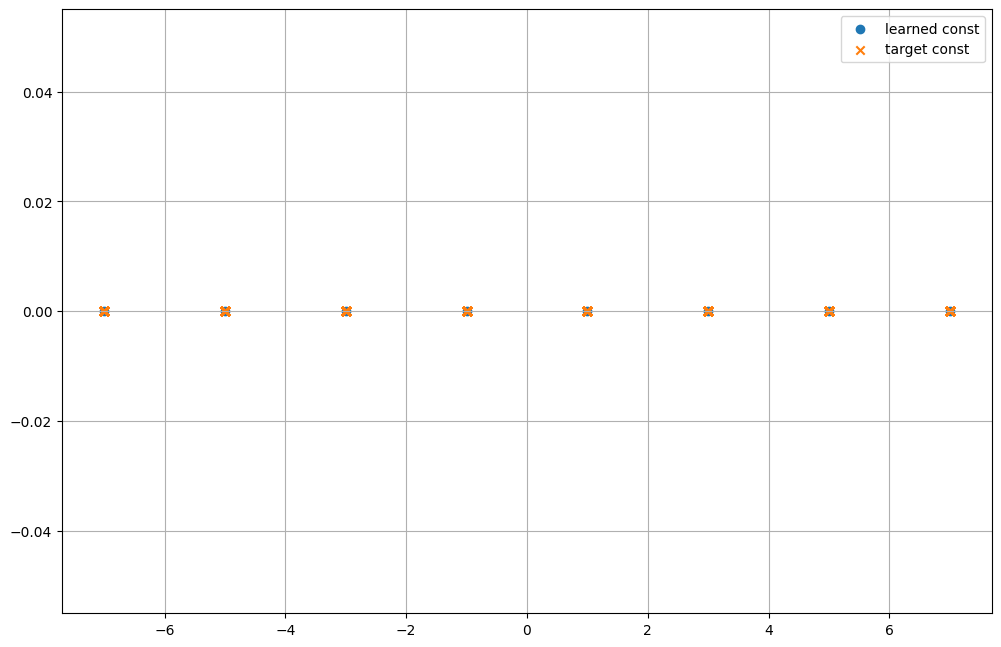

In [11]:
# Data for the plots
a_plot = np.arange(M)
x_plot = classic_mapper(a, alphabet)
onehot_plot = torch.tensor(np.array([one_hot(a_plot[i], M) for i in range(M)])).float()
xhat_plot = mapper2(onehot_plot).detach().numpy()
# Plot
plt.scatter(np.real(xhat_plot),np.imag(xhat_plot), marker="o",label='learned const')
plt.scatter(np.real(x_plot),np.imag(x_plot), marker='x', label='target const')

plt.legend()
plt.grid()

* 3) Let $\boldsymbol{b} = \{b_0, b_1, \dots, b_{m-1} \}$ be a binary representation of message $a$. Identify an input
alphabet $\mathcal{X}$ for which a linear neuron with $m$ inputs cannot realize the mapping $\boldsymbol{b}(a) \mapsto x_a$.

* 4) For the input alphabet you identified in 3), train a linear unit with $m$ inputs using
the MSE loss to verify that the mapping $\boldsymbol{b}(a) \mapsto x_a$ can indeed not be realized.

In [12]:
def get_labeling(msg):
    label = np.array([[0,0,0], [0,0,1], [0,1,1], [0,1,0], [1,1,0], [1,1,1], [1,0,1], [1,0,0]])
    return label[msg, :]

In [13]:
class Mapper3(nn.Module):
    def __init__(self, m):
        super().__init__()
        self.lin1 = nn.Linear(m, 1)
        
    def forward(self, y):
        y = self.lin1(y)
        return y

In [14]:
m = 3
x_t = torch.tensor(x.reshape(-1,1)).float()
bits = get_labeling(a)
bits_t = torch.tensor(bits).float()
# Initialize network
mapper3 = Mapper3(m)
# loss function
loss_fn = nn.MSELoss()
# Optimizer
optimizer = optim.Adam(mapper3.parameters(), lr=0.1)
# Training loop
for j in range(1000):
    x_hat = mapper3(bits_t)
    loss = loss_fn(x_hat, x_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Printout and visualization
    if j % 100 == 0:
        print(f'epoch {j}: Loss = {loss.detach().numpy() :.4f}')

epoch 0: Loss = 22.1300
epoch 100: Loss = 5.2907
epoch 200: Loss = 4.9920
epoch 300: Loss = 4.9919
epoch 400: Loss = 4.9919
epoch 500: Loss = 4.9919
epoch 600: Loss = 4.9919
epoch 700: Loss = 4.9920
epoch 800: Loss = 4.9919
epoch 900: Loss = 4.9919


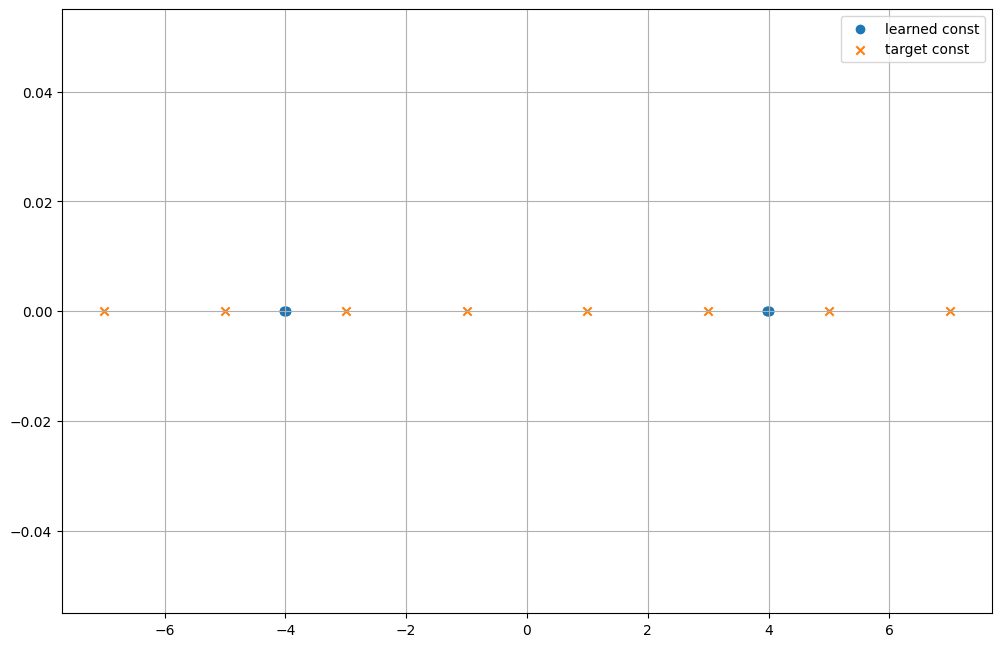

In [15]:
# Data for the plots
A = get_labeling(range(M))
x_plot = classic_mapper(range(M), alphabet)
xhat_plot = mapper3(torch.tensor(A).float()).detach().numpy()
# Plot
plt.scatter(np.real(xhat_plot),np.imag(xhat_plot), marker="o",label='learned const')
plt.scatter(np.real(x_plot),np.imag(x_plot), marker='x', label='target const')
plt.legend()
plt.grid()

* 5) For the input alphabet from 3), devise a non-linear neural network with $m$
inputs that approximates the mapping $\boldsymbol{b}(a) \mapsto x_a$ well w.r.t. the MSE loss.

In [16]:
class Mapper4(nn.Module):
    def __init__(self, m, width):
        super().__init__()
        self.lin1 = nn.Linear(m, width)
        self.act1 = nn.ReLU()
        self.lin2 = nn.Linear(width, width)
        self.act2 = nn.ReLU()
        self.lin3 = nn.Linear(width, 1)
        
    def forward(self, y):
        y = self.act1(self.lin1(y))
        y = self.act2(self.lin2(y))
        return self.lin3(y)

In [17]:
m = 3
nn_width = 10
x_t = torch.tensor(x.reshape(-1,1)).float()
bits = get_labeling(a)
bits_t = torch.tensor(bits).float()
# Initialize network
mapper4 = Mapper4(m, nn_width)
# loss function
loss_fn = nn.MSELoss()
# Optimizer
optimizer = optim.Adam(mapper4.parameters(), lr=0.1)
# Training loop
for j in range(1000):
    x_hat = mapper4(bits_t)
    loss = loss_fn(x_hat, x_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Printout and visualization
    if j % 100 == 0:
        print(f'epoch {j}: Loss = {loss.detach().numpy() :.4f}')
    if loss < 1e-3:
        break

epoch 0: Loss = 21.1130


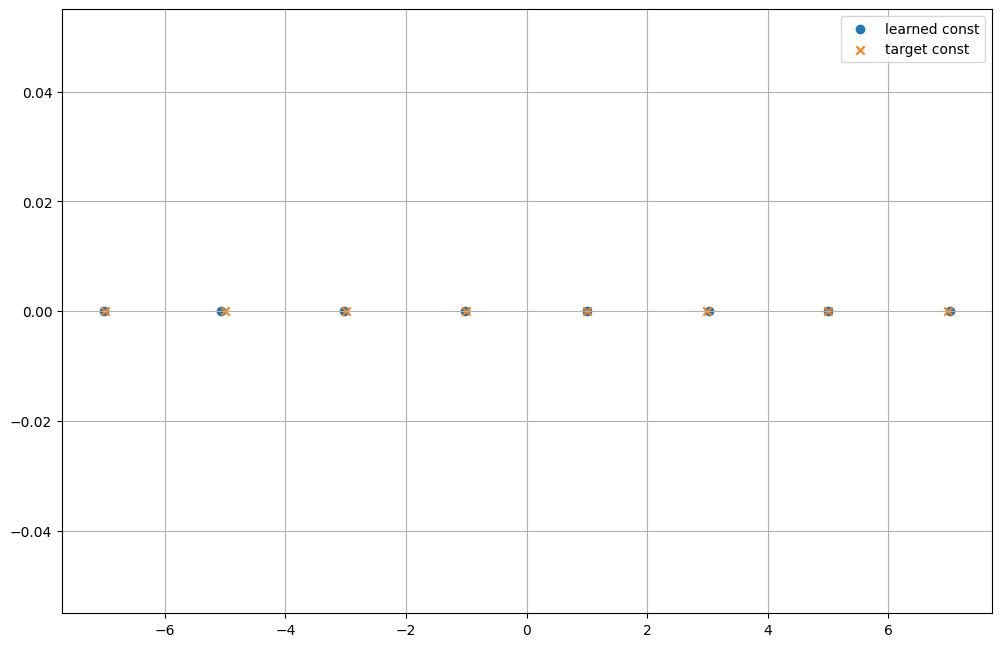

In [18]:
# Data for the plots
A = get_labeling(range(M))
x_plot = classic_mapper(range(M), alphabet)
xhat_plot = mapper4(torch.tensor(A).float()).detach().numpy()
# Plot
plt.scatter(np.real(xhat_plot),np.imag(xhat_plot), marker="o",label='learned const')
plt.scatter(np.real(x_plot),np.imag(x_plot), marker='x', label='target const')

plt.legend()
plt.grid()

##### Problem 6.2 
Consider the channel in the picture.
* 1) Implement the channel as differentiable function supporting torch.autograd using functions provided by torch
* 2) Use a linear neuron with $M$ inputs and one output as transmitter and a linear neuron with one input and M outputs as receiver. 
Sample a message $a \in  \{0,1, \dots, M-1 \}$ and use its one-hot representation $\boldsymbol{u}$ as transmitter input. 
Train transmitter and receiver w.r.t. the cross equivocation $ce(\boldsymbol{u}, \boldsymbol{\ell})$, where $\boldsymbol{\ell}$ is the receiver output.
* 3) Plot the learned channel input alphabet and compare it to the scatterplot of the channel output.

In [19]:
# Channel 
def tanh_channel(x, sigma2, seed=None):
    noise_t = sigma2*torch.randn(len(x),1)
    return torch.add(torch.tanh(x), noise_t)
    #return torch.tanh(x)
#TODO: make it wotk also with additive noise

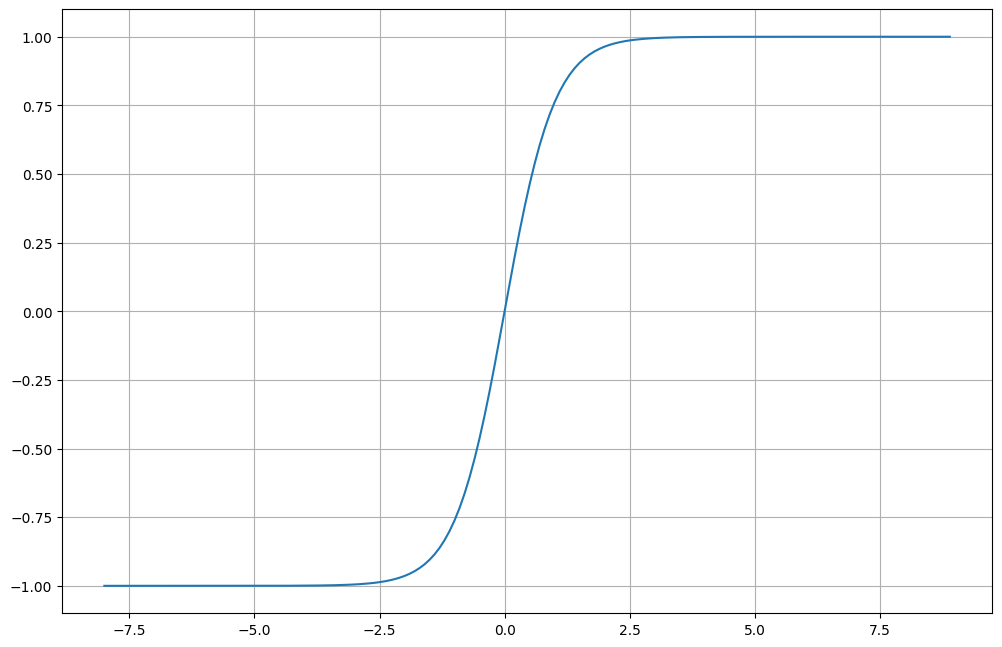

In [20]:
x = np.arange(-8,9,0.1)
plt.plot(x, np.tanh(x))
plt.grid()

In [21]:
# Transmitter and receiver NNs
class Tanh_transmitter(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(M, 1)

    def forward(self, y):
        y = self.lin1(y)
        return y
    
class Tanh_receiver(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(1, M)

    def forward(self, y):
        y = self.lin1(y)
        return y    

In [22]:
# Create data
n = 100000
snrdB = 20
snr = 10**(snrdB/10)
sigma2 = 1/snr
a = np.random.choice(range(M), size=n)
onehot = np.array([one_hot(a[i], M) for i in range(n)])

In [23]:
# Initialize networks
tx = Tanh_transmitter(M)
rx = Tanh_receiver(M)
# Loss function
loss_fn = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(list(tx.parameters()) + list(rx.parameters()), lr=0.1)

In [24]:
 # Batches
batch_size = 100
onehot_t = torch.tensor(onehot).float()
a_t = torch.tensor(a)
a_t = a_t.type(torch.LongTensor)

In [25]:
# Training loop
for j in range(10000):
    x = tx(onehot_t)
    y = tanh_channel(x, sigma2).float()
    l = rx(y)
    loss = loss_fn(l, a_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Printout and visualization
    if j % 1000 == 0:
        print(f'epoch {j}: Loss = {loss.detach().numpy() :.4f}')
    if loss < 1e-3:
        break

epoch 0: Loss = 2.1930
epoch 1000: Loss = 0.6166
epoch 2000: Loss = 0.3728
epoch 3000: Loss = 0.2002
epoch 4000: Loss = 0.1868
epoch 5000: Loss = 0.0383
epoch 6000: Loss = 0.0198
epoch 7000: Loss = 0.0139
epoch 8000: Loss = 0.0095
epoch 9000: Loss = 0.0063


In [26]:
# Data for the plots
a_plot = np.arange(M)
onehot_plot = np.array([one_hot(a_plot[i], M) for i in range(M)])
learned_x = tx(torch.tensor(onehot_plot).float())
yy_plot = torch.tanh(learned_x)

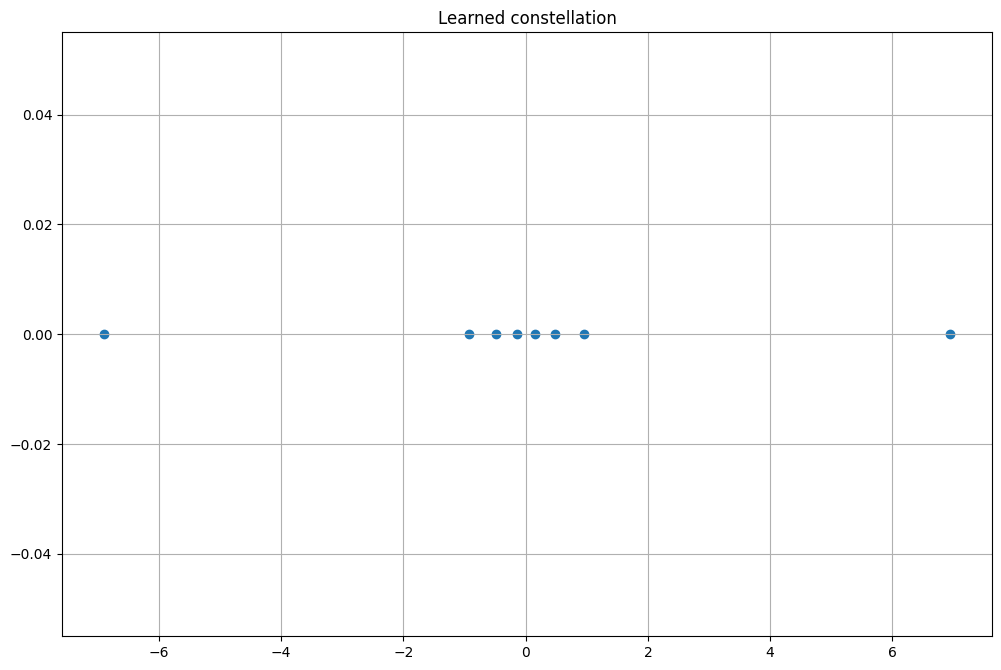

In [27]:
# Plot
plt.scatter(np.real(learned_x.detach().numpy()), np.imag(learned_x.detach().numpy()))
plt.title('Learned constellation')
plt.grid()

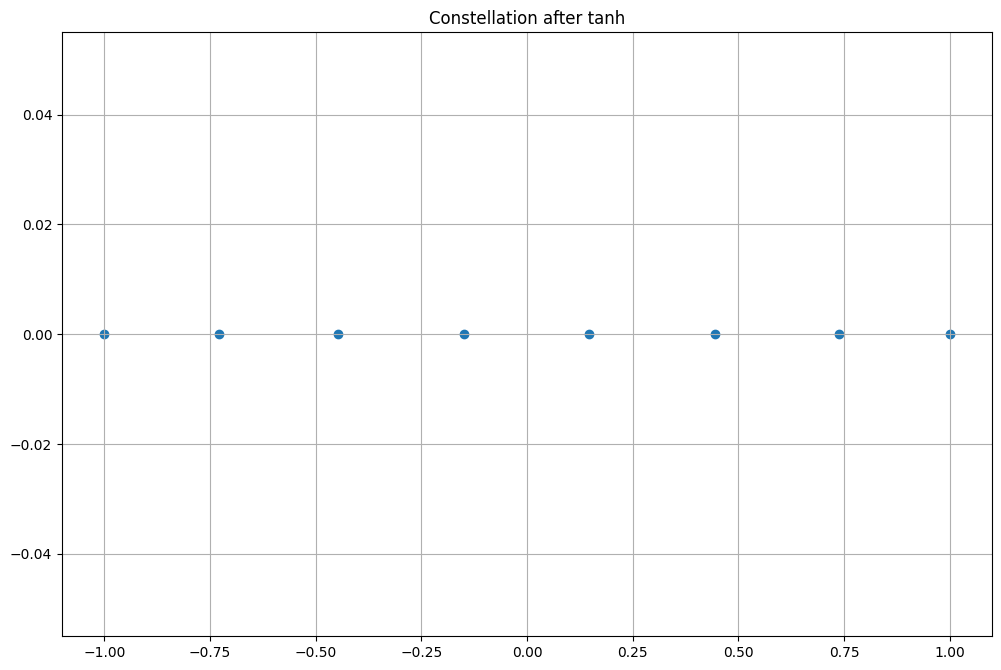

In [28]:
plt.scatter(np.real(yy_plot.detach().numpy()), np.imag(yy_plot.detach().numpy()))
plt.title('Constellation after tanh')
plt.grid()

In [29]:
def message(onehot):
    return np.where(onehot == 1) # integers

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def recover_onehot(soft_decision):
     max_index = np.where(soft_decision == np.amax(soft_decision))
     onehot = np.zeros(len(soft_decision))
     onehot[max_index] = 1
     return onehot

In [30]:
# Create test data
n = 100
a_test = np.random.choice(range(M), size=n)
onehot_test = np.array([one_hot(a_test[i], M) for i in range(n)])
x_test = tx(torch.tensor(onehot_test).float()) # mapped symbols
y_test = tanh_channel(x_test, sigma2).float()
x_hat_test = [recover_onehot(softmax(i)) for i in rx(y_test).detach().numpy()]
a_hat_test = np.array([message(i)[0].tolist()[0] for i in x_hat_test])

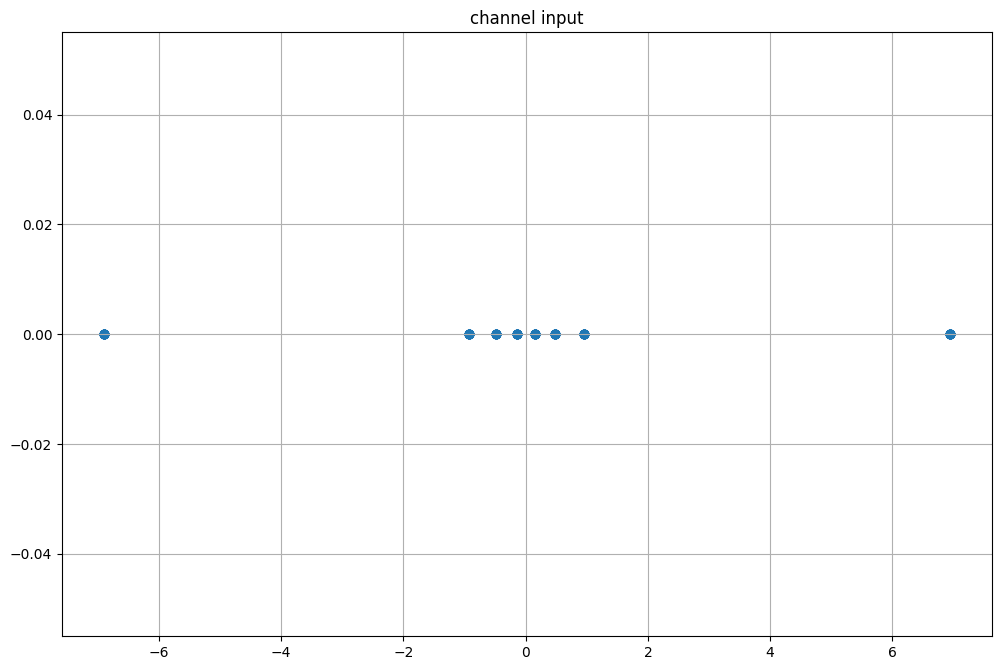

In [31]:
# Plot
plt.scatter(np.real(x_test.detach().numpy()), np.imag(x_test.detach().numpy()))
plt.title('channel input')
plt.grid()

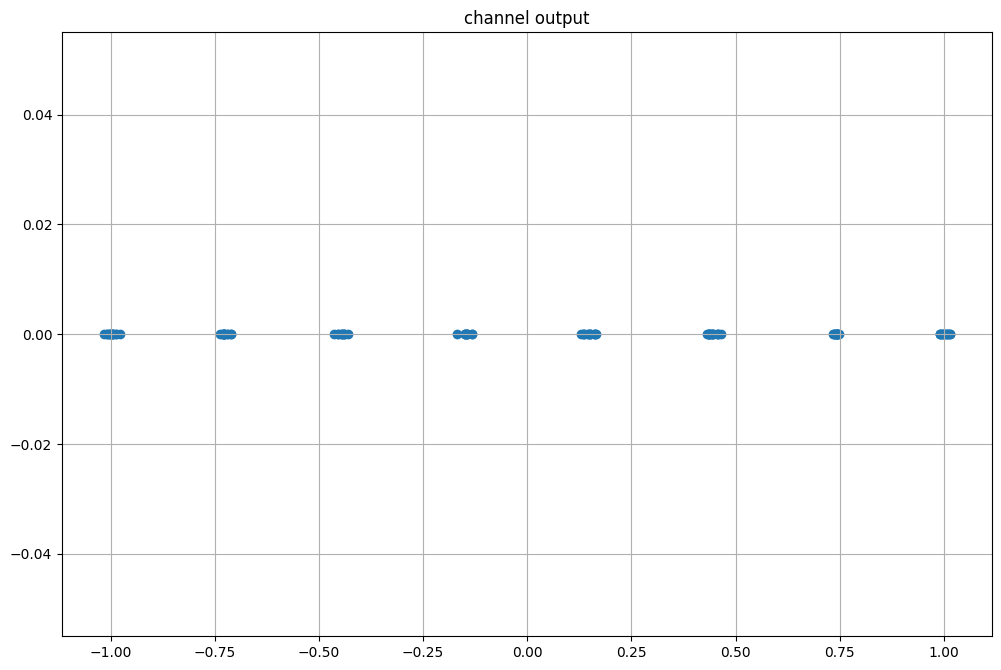

In [32]:
# Plot
plt.scatter(np.real(y_test.detach().numpy()), np.imag(y_test.detach().numpy()))
plt.title('channel output')
plt.grid()

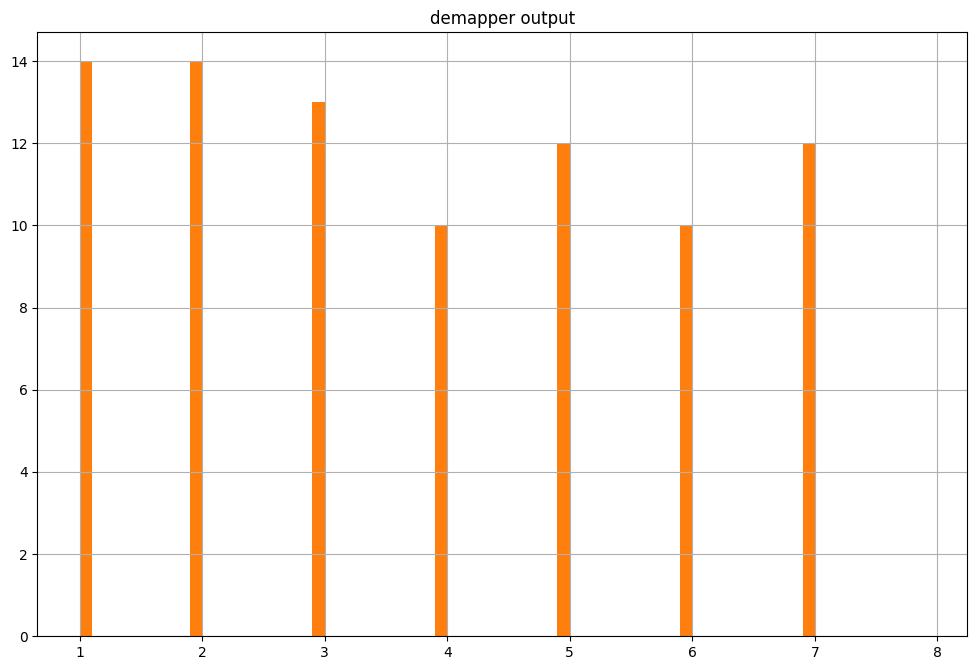

In [33]:
# Plot
plt.hist(a_hat_test, bins=np.arange(1, 7, 0.1))
plt.hist(a_test, bins=np.arange(1, 8, 0.1))
plt.title('demapper output')
plt.grid()

##### Problem 6.3
Consider an SNR constraint as introduced in Section 6.1.3. Specifically, we consider a complex signal, which we represent by a real signal where two successive real symbols are the inphase and quadrature
components, respectively, of one complex symbol, i.e.,

$x_{2i} x_{2i+1} \leftrightarrow  c_{i} = x_{2i} + jx_{2i+1}$

We normalize the average power of the signal, i.e., for a batch size of $n_{batch}$ complex symbols, we impose:

$\frac{1}{n_{batch}}\sum \limits _{i=0} ^{n_{batch}-1} x_{i}^{2} = P $

After normalization, we add zero mean Gaussian noise.

The task is now to learn a 2D constellation with 16 complex symbols.
1. Implement the normalization layer followed by AWGN as differentiable function
in pytorch.
2. For a one-hot representation of the message, implement a linear unit with M = 16
inputs and 2 outputs as a mapper at the transmitter, and a linear unit with 2
inputs and M = 16 outputs as demapper at the receiver.
3. Jointly train mapper and demapper w.r.t. CE loss for SNR equal to 0, 2, . . . , 10
dB and plot the learned constellations.

In [17]:
# SNR Channel 
def snr_channel(x, snr, seed=None):
    P = 1 # Normalization Factor
    sigma2 = P/snr
    c = torch.mean(x**2)
    norm_x = torch.sqrt(P / c) * x
    noise_t = np.sqrt(sigma2)*torch.randn(x.shape)
    return torch.add(x, noise_t)


In [27]:
def normalization(x, P):
    c = torch.mean(x**2)
    return torch.sqrt(P / c) * x

In [28]:
def awgn(x, sigma2):
    noise_t = np.sqrt(sigma2)*torch.randn(x.shape)
    return torch.add(x, noise_t)

In [3]:
# Transmitter and receiver NNs
class Snr_transmitter(nn.Module):
  def __init__(self, M):
    super().__init__()
    self.lin1 = nn.Linear(M, 32)
    self.lin2 = nn.Linear(32, 32)
    self.lin3 = nn.Linear(32, 2)
        
  def forward(self, y):
    return self.lin3(self.lin2(self.lin1(y)))
    
class Snr_receiver(nn.Module):
  def __init__(self, M):
    super().__init__()
    self.lin1 = nn.Linear(2, 32)
    self.lin2 = nn.Linear(32, 32)
    self.lin3 = nn.Linear(32, M)
        
  def forward(self, y):
      return self.lin3(self.lin2(self.lin1(y)))

In [41]:
def train_snr_scheme(num_epochs, dataloader, labelloader, sigma2, tx, rx, loss_fn, optimizer):
  loss_last_batch = []
  for j in range(num_epochs):
      for data, label in zip(dataloader, labelloader):
          #x = tx(data)
          #y = snr_channel(x, snr)
          #l = rx(y)
          xhat = tx(data)
          xhat = normalization(xhat, P)
          yhat = awgn(xhat, sigma2)
          l = rx(yhat)
          loss = loss_fn(l, label)
          loss_last_batch.append(loss.detach().numpy())
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      # Printout and visualization
      if j % 10 == 0:
          print(f'epoch {j}: Loss = {loss.detach().numpy()/np.log(2) :.4f} dB')
      if loss < 1e-3:
          break
  return loss_last_batch

In [30]:
# Generate data
M = 16
n = 100000
P = 1
snrdBs = np.array([0,2,4,6,8,10])
snrs = 10**(snrdBs/10)

a = np.random.choice(range(M), size=n)
onehot = np.array([one_hot(a[i], M) for i in range(n)])

# Convert array to tensor
a_t = torch.tensor(a).type(torch.LongTensor)
onehot_t = torch.tensor(onehot).float()

# Data Loader
dataloader = torch.utils.data.DataLoader(onehot_t, batch_size=batch_size)
labelloader = torch.utils.data.DataLoader(a_t, batch_size=batch_size)

#Loss Function
loss_fn = nn.CrossEntropyLoss()

In [ ]:
loss_batches = []
num_epochs = 100
batch_size = 5000

# Initialize networks
txs = [] 
rxs = []

for idx, snr in enumerate(snrs):
  print(f'--- SNR is: {snrdBs[idx]} dB---')
  sigma2 = P/snr
  #Initialize Networks
  txs.append(Snr_transmitter(M))
  rxs.append(Snr_receiver(M))
  # Optimizer
  optimizer = optim.Adam(list(txs[idx].parameters()) + list(rxs[idx].parameters()), lr=0.01)
    
  loss_last_batch = train_snr_scheme(num_epochs, dataloader, labelloader, sigma2, txs[idx], rxs[idx], loss_fn, optimizer)
  loss_batches.append(loss_last_batch)

  


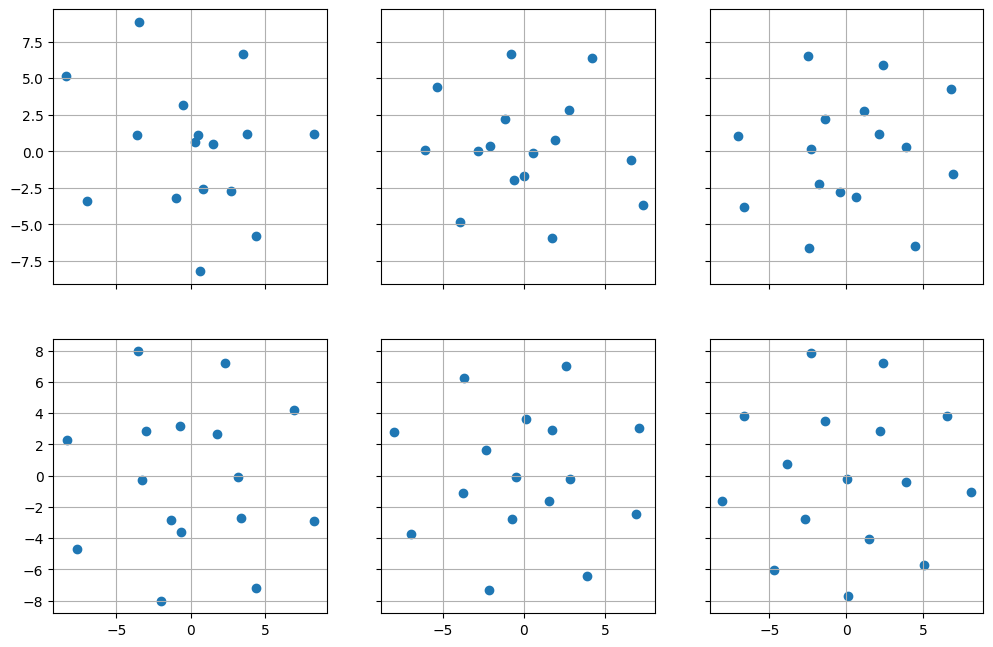

In [35]:
# Plot the learned constelation
fig, ax = plt.subplots(2, int(len(snrdBs)/2), sharex='col', sharey='row')
#fig, ax = plt.subplots(2, int(len(snrdBs)/2))
a_plot = np.arange(M)
onehot_plot = np.array([one_hot(a_plot[i], M) for i in range(M)])

for idx in range(len(snrdBs)):  
  learned_x = txs[idx](torch.tensor(onehot_plot).float())
  learned_x = snr_channel(learned_x,snrs[idx])
  learned_x = learned_x.detach().numpy()
  #yy_plot = snr_channel(learned_x, snrdB)

  i = idx // int(len(snrdBs)/2)
  j = idx % int(len(snrdBs)/2)
  ax[i, j].scatter(learned_x[:,0], learned_x[:,1])
  #ax[i, j].title(f'SNR={snrdB} dB')
  ax[i, j].grid()
  #fig.show()

In [ ]:
#Plot the loss
for idx, batch in enumerate(loss_batches):
  plt.figure(figsize=(6,3), dpi= 100, facecolor='w', edgecolor='k')
  plt.plot(np.arange(len(batch)), batch, label=f'Train SNR={snrdBs[idx]} dB')
  plt.xlabel('Epoch index')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid()
  plt.show()



4. For a binary representation of the message, implement a non-linear NN with m = 4
inputs and 2 outputs as mapper at the transceiver and a non-linear NN with
2 inputs terminated by a linear layer with m = 4 outputs as demapper at the
receiver.
5. Jointly train mapper and demapper w.r.t. BCE loss on LPRs for SNR equal to
0, 2, . . . , 10 dB and plot the learned constellations.
6. Verify if the learned bit mappings are Gray

In [37]:
# Transmitter and receiver NNs
class Binary_snr_transmitter(nn.Module):
    def __init__(self, M, width):
        super().__init__()
        self.lin1 = nn.Linear(M, width)
        self.act1 = nn.ReLU()
        self.lin2 = nn.Linear(width, width)
        self.act2 = nn.ReLU()
        self.lin3 = nn.Linear(width, 2)
        
    def forward(self, y):
        y = self.act1(self.lin1(y))
        y = self.act2(self.lin2(y))
        return self.lin3(y)
    
class Binary_snr_receiver(nn.Module):
    def __init__(self, M, width):
        super().__init__()
        self.lin1 = nn.Linear(2, width)
        self.act1 = nn.ReLU()
        self.lin2 = nn.Linear(width, width)
        self.act2 = nn.ReLU()
        self.lin3 = nn.Linear(width, M)
        
    def forward(self, y):
        y = self.act1(self.lin1(y))
        y = self.act2(self.lin2(y))
        return self.lin3(y)

In [38]:
def get_labeling(msg):
    label = np.array([[0,0,0,0], [0,0,0,1], [0,0,1,0], [0,0,1,1], [0,1,0,0], [0,1,0,1], [0,1,1,0], [0,1,1,1],
                      [1,0,0,0], [1,0,0,1], [1,0,1,0], [1,0,1,1], [1,1,0,0], [1,1,0,1], [1,1,1,0], [1,1,1,1]])
    return label[msg, :]

In [39]:
# Generate data
M = 16
n = 100000
nn_width = 20
snrdBs = np.array([0,2,4,6,8,10])
snrs = 10**(snrdBs/10)

a = np.random.choice(range(M), size=n)
binary = np.array([get_labeling(a[i]) for i in range(n)])

# Convert to tensor
binary_t = torch.tensor(binary).float()
a_t = torch.tensor(binary).float()

# Loss Function
loss_fn = nn.BCEWithLogitsLoss()

In [53]:
binary_t

tensor([[1., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 1., 1.],
        ...,
        [0., 1., 0., 0.],
        [0., 0., 1., 1.],
        [0., 1., 1., 1.]])

In [ ]:
txs = []
rxs = []

for idx, snr in enumerate(snrs):
  print(f'--- SNR is: {snrdBs[idx]} dB---')
  
  sigma2 = P/snr
  # Initialize networks
  txs.append(Binary_snr_transmitter(4, nn_width))
  rxs.append(Binary_snr_receiver(4, nn_width))
  # Loss function


  # Optimizer
  optimizer = optim.Adam(list(txs[idx].parameters()) + list(rxs[idx].parameters()), lr=0.1)
  # Data Loader
  dataloader = torch.utils.data.DataLoader(binary_t, batch_size=batch_size)
  labelloader = torch.utils.data.DataLoader(binary_t, batch_size=batch_size)
  

  loss_last_batch = train_snr_scheme(num_epochs, dataloader, labelloader, sigma2, txs[idx], rxs[idx], loss_fn, optimizer)
  loss_batches.append(loss_last_batch)

--- SNR is: 0 dB---
epoch 0: Loss = 0.9363 dB
epoch 10: Loss = 0.8160 dB
epoch 20: Loss = 0.8204 dB
epoch 30: Loss = 0.7656 dB
epoch 40: Loss = 0.7594 dB
epoch 50: Loss = 0.7580 dB
epoch 60: Loss = 0.7573 dB
epoch 70: Loss = 0.7536 dB
epoch 80: Loss = 0.7597 dB


In [ ]:
fig, ax = plt.subplots(2, int(len(snrdBs)/2))

for idx in range(len(snrdBs)):
  a_plot = np.arange(M)
  onehot_plot = np.array([get_labeling(a_plot[i]) for i in range(M)])
  learned_x = txs[idx](torch.tensor(onehot_plot).float())
  yy_plot = snr_channel(learned_x, snrdB)
  
  # Plot the learned constelation
  i = idx // int(len(snrdBs)/2)
  j = idx % int(len(snrdBs)/2)
  ax[i, j].scatter(learned_x.detach().numpy()[:,0], learned_x.detach().numpy()[:,1])

In [ ]:
#Plot the loss
for idx, batch in enumerate(loss_batches):
  plt.plot(np.arange(len(batch)), batch, label=f'Train SNR={snrdBs[idx]} dB')
  plt.xlabel('Epoch index')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid()
  plt.show()